**Download and unzip data**

In [1]:
# comment this out after unzipping once
! wget https://scholar.cu.edu.eg/Dataset_BUSI.zip
! unzip /content/Dataset_BUSI.zip

--2021-04-09 13:15:28--  https://scholar.cu.edu.eg/Dataset_BUSI.zip
Resolving scholar.cu.edu.eg (scholar.cu.edu.eg)... 195.246.42.194
Connecting to scholar.cu.edu.eg (scholar.cu.edu.eg)|195.246.42.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 205873341 (196M) [application/zip]
Saving to: ‘Dataset_BUSI.zip’

Dataset_BUSI.zip    100%[===================>] 196.34M   225KB/s    in 13m 40s 

2021-04-09 13:29:09 (245 KB/s) - ‘Dataset_BUSI.zip’ saved [205873341/205873341]

Archive:  /content/Dataset_BUSI.zip
   creating: Dataset_BUSI_with_GT/
   creating: Dataset_BUSI_with_GT/benign/
  inflating: Dataset_BUSI_with_GT/benign/benign (1).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (1)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask.png  
  inflating: Da

**Import necessary libraries**

In [2]:
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split

**Load and Preprocess Data**

In [3]:
def parse_images(root_dir, size=(128, 128)):
  root_dir = [os.path.join(root_dir, path) for path in os.listdir(root_dir)]


  data = []
  masks = []


  for i in range(len(root_dir) // 2):
    path = [path for path in root_dir if (f'({i+1})' in path)]
    if len(path) == 2:
      path1, path2 = path
      if 'mask' in path1:
        mask_path = path1
        img_path = path2
      else:
        mask_path = path2
        img_path = path1
      
      img = cv2.imread(img_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      img = cv2.resize(img, size) / 255.
      mask = cv2.imread(mask_path)
      mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
      mask = cv2.resize(mask, size) / 255.
      data.append(img)
      masks.append(mask)

  return data, masks


In [4]:
benign_imgs, benign_masks =  parse_images('/content/Dataset_BUSI_with_GT/benign')
malignant_imgs, malignant_masks = parse_images('/content/Dataset_BUSI_with_GT/malignant')
normal_imgs,  normal_masks = parse_images('/content/Dataset_BUSI_with_GT/normal')


benign_imgs_train, benign_imgs_test, benign_masks_train, benign_masks_test = train_test_split(benign_imgs, benign_masks,
                                                                                              test_size=0.2,
                                                                                              shuffle=True, random_state=42)
malignant_imgs_train, malignant_imgs_test, malignant_masks_train, malignant_masks_test = train_test_split(malignant_imgs, malignant_masks,
                                                                                                          test_size=0.2,
                                                                                                          shuffle=True, random_state=42)
normal_imgs_train, normal_imgs_test, normal_masks_train, normal_masks_test = train_test_split(normal_imgs, normal_masks,
                                                                                              test_size=0.2,
                                                                                              shuffle=True, random_state=42)


X_train = np.concatenate((benign_imgs_train, malignant_imgs_train, normal_imgs_train))
Y_train = np.concatenate((benign_masks_train, malignant_masks_train, normal_masks_train))

X_test = np.concatenate((benign_imgs_test, malignant_imgs_test, normal_imgs_test))
Y_test = np.concatenate((benign_masks_test, malignant_masks_test, normal_masks_test))

**Visualization**

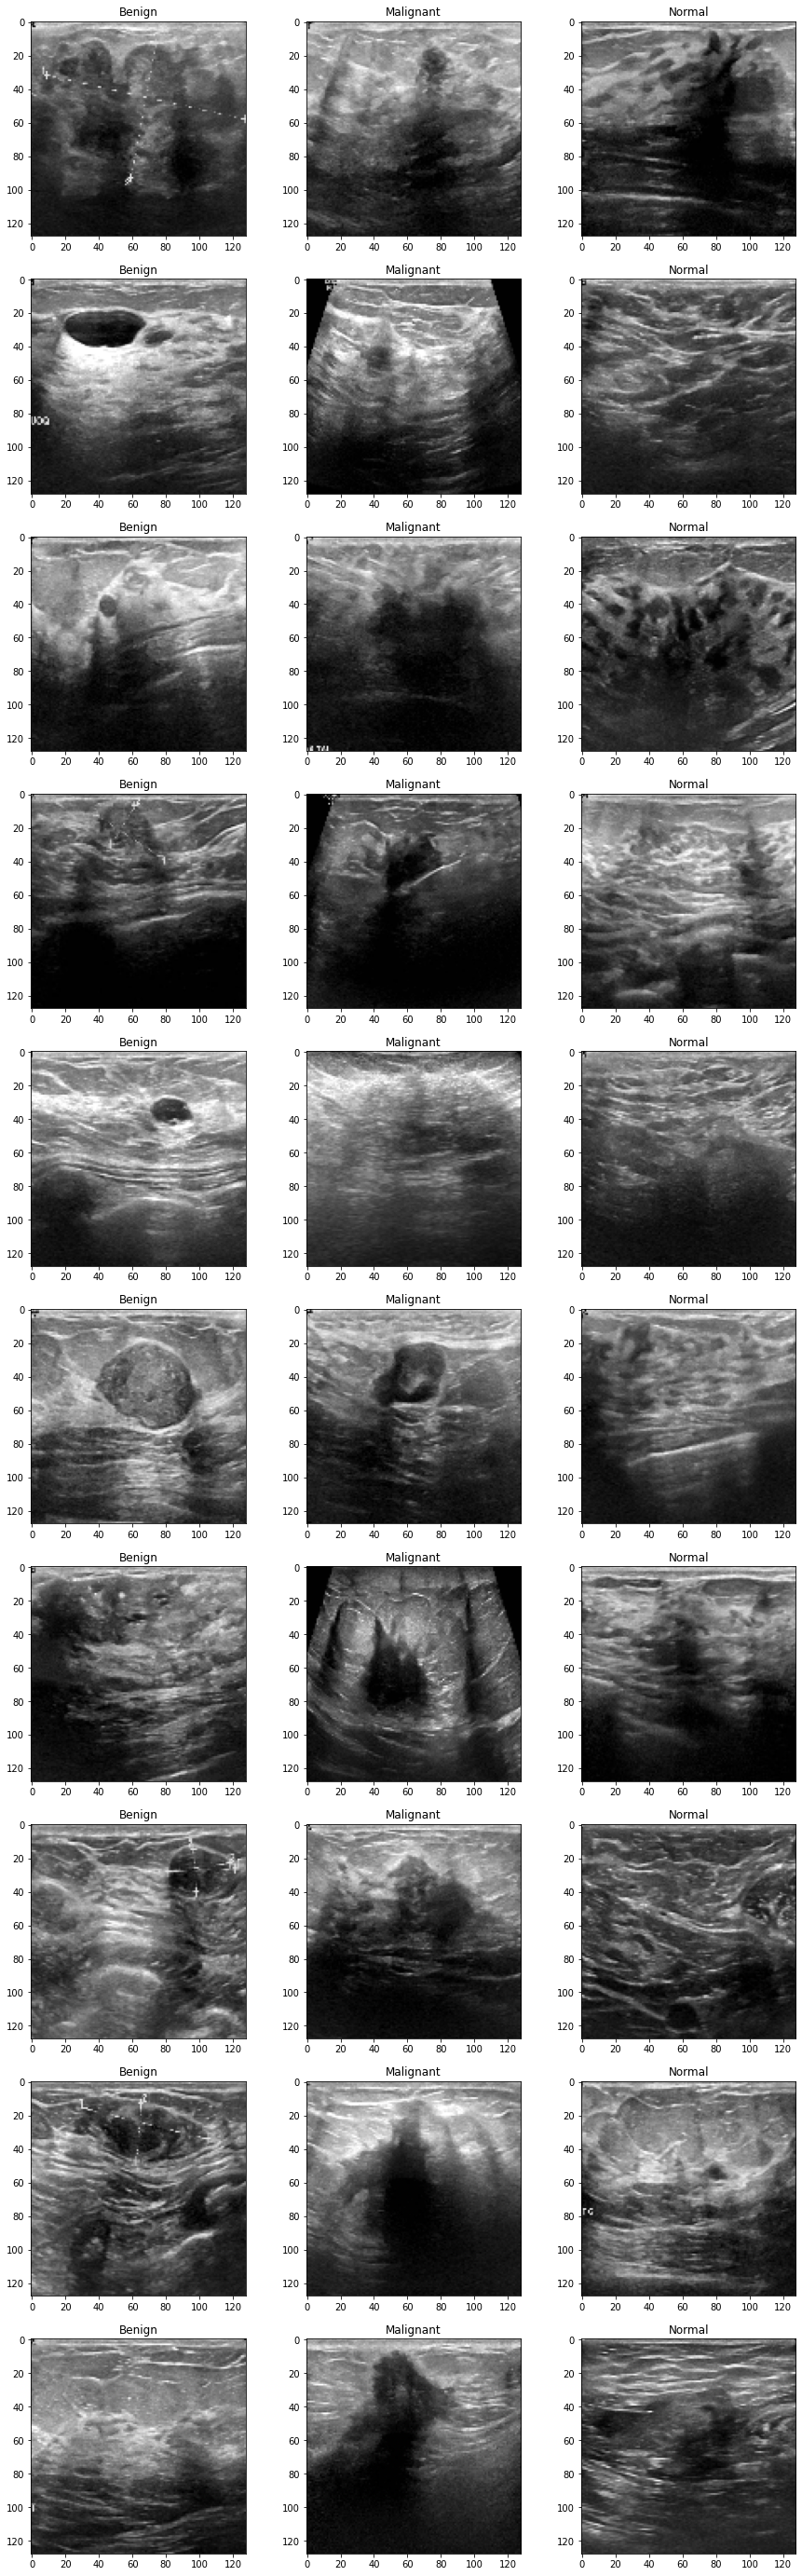

In [20]:
import matplotlib.pyplot as plt

show_num = 10
fig, ax = plt.subplots(show_num, 3, figsize=(15, 50))

for i, pred in enumerate(benign_imgs_train[:show_num]):
    ax[i, 0].imshow(benign_imgs_train[i], cmap='gray')
    ax[i, 0].set_title('Benign')
    ax[i, 1].imshow(malignant_imgs_train[i], cmap='gray')
    ax[i, 1].set_title('Malignant')
    ax[i, 2].imshow(normal_imgs_train[i], cmap='gray')
    ax[i, 2].set_title('Normal')


In [5]:
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

(609, 128, 128)
(609, 128, 128)
(154, 128, 128)
(154, 128, 128)


**Define Model**

In [10]:
import keras
from keras import models
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Activation, Lambda, Conv2D, \
    MaxPooling2D, UpSampling2D,Input, Concatenate, Conv2DTranspose
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.backend as K
from sklearn import model_selection, metrics
from sklearn.metrics import classification_report
import math

class UNet(object):
    def __init__(self, img_shape, num_of_class, actf = 'relu',
        learning_rate = 0.001,  drop_rate = 0.5, do_batch_norm = False, do_drop = False):

        '''
        Arguments :

        img_shape - shape of input image (64, 64, 1)
        actf - activation function for network training
        learning_rate - learning rate for training
        drop_rate - dropout rate
        do_batch_norm - whether to run for batchnormalization
        do_drop - whether to run for dropout
        '''

        self.learning_rate = learning_rate
        self.actf = actf
        self.img_shape = img_shape
        self.num_of_class = num_of_class
        self.drop_rate = drop_rate
        self.do_batch_norm = do_batch_norm
        self.do_drop = do_drop

        self.model = self.build_model()

    # encoding block(conv - conv - pool)
    def enc_conv_block(self, inputs, feature_maps, filter_size = (3, 3),
                           conv_strides = 1, pooling_filter_size = (2, 2), pooling_strides = (2, 2)):
        conv1 = Conv2D(feature_maps , filter_size , activation = self.actf, strides = conv_strides,
                           padding = 'same', kernel_initializer = 'he_normal')(inputs)
        conv2 = Conv2D(feature_maps , filter_size , activation = self.actf, strides = conv_strides,
                           padding = 'same', kernel_initializer = 'he_normal')(conv1)
        pool = MaxPooling2D(pooling_filter_size, strides = pooling_strides)(conv2)

        return pool, conv2

    # decoding block(concat - upconv - upconv)
    def dec_conv_block(self, inputs, merge_inputs, feature_maps, filter_size = (3, 3), conv_strides = 1,
                           up_conv_strides = (2, 2)):

        merge = Concatenate(axis = 3)([Conv2DTranspose(feature_maps, filter_size,
                                                       activation = self.actf, strides = up_conv_strides, kernel_initializer = 'he_normal',
                                                       padding = 'same')(inputs), merge_inputs])

        conv1 = Conv2D(feature_maps , filter_size , activation = self.actf, strides = conv_strides,
                           padding = 'same', kernel_initializer = 'he_normal')(merge)
        conv2 = Conv2D(feature_maps , filter_size , activation = self.actf, strides = conv_strides,
                           padding = 'same', kernel_initializer = 'he_normal')(conv1)

        return conv2

    # encoder
    def encoding_path(self, inputs):

        enc_conv1, concat1 = self.enc_conv_block(inputs, 64)
        enc_conv2, concat2 = self.enc_conv_block(enc_conv1, 128)
        enc_conv3, concat3 = self.enc_conv_block(enc_conv2, 256)
        enc_conv4, concat4 = self.enc_conv_block(enc_conv3, 512)

        return concat1, concat2, concat3, concat4, enc_conv4

    # decoder
    def decoding_path(self, dec_inputs, concat1, concat2, concat3, concat4):

        dec_conv1 = self.dec_conv_block(dec_inputs, concat4, 512)
        dec_conv2 = self.dec_conv_block(dec_conv1, concat3, 256)
        dec_conv3 = self.dec_conv_block(dec_conv2, concat2, 128)
        dec_conv4 = self.dec_conv_block(dec_conv3, concat1, 64)

        return dec_conv4
    # build network
    def build_model(self):
        inputs = Input(self.img_shape)

        # Contracting path
        concat1, concat2, concat3, concat4, enc_path = self.encoding_path(inputs)

        # middle path
        mid_path1 = Conv2D(1024, (3,3), activation = self.actf, padding = 'same', kernel_initializer = 'he_normal')(enc_path)
        mid_path1 = Dropout(self.drop_rate)(mid_path1)
        mid_path2 = Conv2D(1024, (3,3), activation = self.actf, padding = 'same', kernel_initializer = 'he_normal')(mid_path1)
        mid_path2 = Dropout(self.drop_rate)(mid_path2)

        # Expanding path
        dec_path = self.decoding_path(mid_path2, concat1, concat2, concat3, concat4)
        segmented = Conv2D(self.num_of_class, (1,1), activation ='sigmoid', padding = 'same', kernel_initializer = 'glorot_normal')(dec_path)


        model = Model(inputs = inputs, outputs = segmented)
        model.compile(optimizer = Adam(lr = self.learning_rate),
                          loss = 'binary_crossentropy', metrics = [dice_coef])

        return model

    # train model
    def train(self, X_train, Y_train, epoch = 10, batch_size = 32, val_split = 0.2, shuffle = True):

        self.history = self.model.fit(X_train, Y_train, validation_split = val_split,
                                          epochs = epoch, batch_size = batch_size, shuffle =  shuffle)
        return self.history

    # predict test data
    def predict(self, X_test):
        pred_classes = self.model.predict(X_test)

        return pred_classes

    # show u-net architecture
    def show_model(self):
        return print(self.model.summary())





# data evalutate function
def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true) + K.sum(y_pred) + K.epsilon())

# data pre-processing function
# standardization of data
def data_std(X_train, X_test):
    mean = np.mean(X_train, axis=(0, 1, 2, 3))
    std = np.std(X_train, axis=(0, 1, 2, 3))

    X_train = (X_train - mean)/(std + 1e-7)
    X_test = (X_test - mean)/(std + 1e-7)

    return X_train, X_test

# plot history for accuracy
def plot_dice(history, title = None):
    fig = plt.figure()
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['dice_coef'])
    plt.plot(history['val_dice_coef'])
    if title is not None:
        plt.title(title)

    plt.ylabel('Dice_coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc=0)

# plot history for accuracy
def plot_acc(history, title = None):
    fig = plt.figure()
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    if title is not None:
        plt.title(title)

    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc=0)



# plot history for loss
def plot_loss(history, title = None):
    fig = plt.figure()
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    if title is not None:
        plt.title(title)

    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    plt.legend(['Train', 'Val'], loc=0)


In [11]:
seg_model = UNet(img_shape = (128,128,1),num_of_class = 1, do_drop = True, drop_rate = 0.3,learning_rate = 2e-4)
model = seg_model.model
seg_model.show_model()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 64) 36928       conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 64, 64, 64)   0           conv2d_20[0][0]                  
____________________________________________________________________________________________

**Training**

In [12]:
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='Cancer.h5',
    save_weights_only=True,
    monitor='val_dice_coef',
    mode='max',
    save_best_only=True)
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 100, callbacks=[callback])

Epoch 1/100
20/20 [==============================] - 58s 766ms/step - loss: 0.4403 - dice_coef: 0.0989 - val_loss: 0.3226 - val_dice_coef: 0.1253
Epoch 2/100
20/20 [==============================] - 8s 396ms/step - loss: 0.2994 - dice_coef: 0.1189 - val_loss: 0.2850 - val_dice_coef: 0.1540
Epoch 3/100
20/20 [==============================] - 8s 396ms/step - loss: 0.3281 - dice_coef: 0.1282 - val_loss: 0.3198 - val_dice_coef: 0.1248
Epoch 4/100
20/20 [==============================] - 8s 396ms/step - loss: 0.3119 - dice_coef: 0.1162 - val_loss: 0.3008 - val_dice_coef: 0.1460
Epoch 5/100
20/20 [==============================] - 8s 398ms/step - loss: 0.2948 - dice_coef: 0.1363 - val_loss: 0.3105 - val_dice_coef: 0.1268
Epoch 6/100
20/20 [==============================] - 8s 400ms/step - loss: 0.2753 - dice_coef: 0.1437 - val_loss: 0.2291 - val_dice_coef: 0.2003
Epoch 7/100
20/20 [==============================] - 8s 402ms/step - loss: 0.2355 - dice_coef: 0.2174 - val_loss: 0.2045 - val_di

**Predicition**

In [13]:
preds = model.predict(X_test)

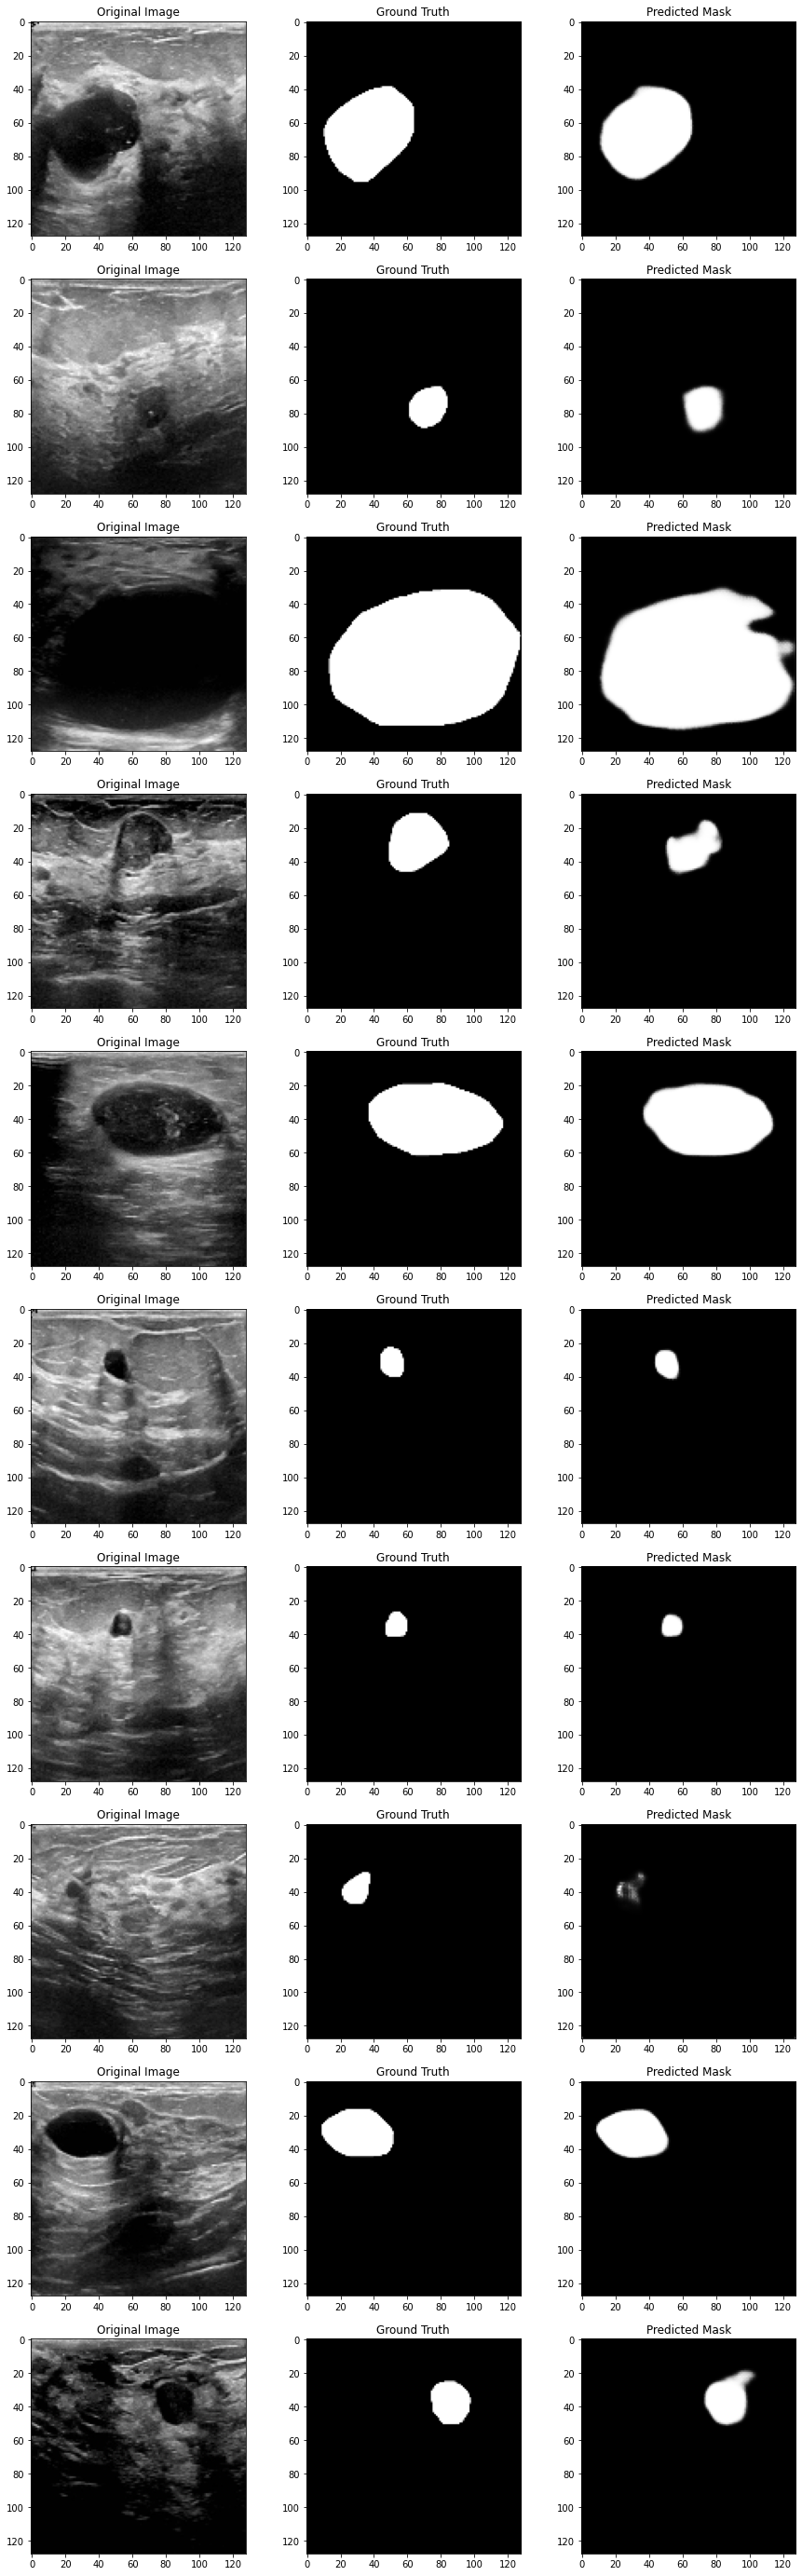

In [14]:
import matplotlib.pyplot as plt

show_num = 10
fig, ax = plt.subplots(show_num, 3, figsize=(15, 50))

for i, pred in enumerate(preds[:show_num]):
    ax[i, 0].imshow(X_test[i].squeeze(), cmap='gray')
    ax[i, 0].set_title('Original Image')
    ax[i, 1].imshow(Y_test[i].squeeze(), cmap='gray')
    ax[i, 1].set_title('Ground Truth')
    ax[i, 2].imshow(pred.squeeze(), cmap='gray')
    ax[i, 2].set_title('Predicted Mask')
